### the purpose of this notebook is to train a language model on combined subjective notes and medical history

In [1]:
from fastai import *
from fastai.tabular import *
from fastai.text import *

In [2]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from collections import Counter
import random

In [3]:
path = '/floyd/home/notebooks'
data_path = '/floyd/home/data'
model_path = '/floyd/home/models'

In [35]:
df1 = pd.read_csv(data_path +'/targets.csv', index_col=0)
df2 = pd.read_csv(data_path + '/subj_data.csv', index_col=0)
data = pd.concat([df1,df2],axis = 1)

In [36]:
len(data), len(df2), len(df1)

(136993, 136993, 136993)

In [39]:
data.head()

,outcome,target,service,target2,discharge,target3,dispo,SubjectiveNotes,MedicalHistory,pmhx
0,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,NaN
1,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,NaN
2,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,NaN
3,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,NaN
4,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,NaN


In [42]:
data.columns

Index(['outcome', 'target', 'service', 'target2', 'discharge', 'target3',
       'dispo', 'SubjectiveNotes', 'MedicalHistory', 'pmhx'],
      dtype='object')

In [48]:
data.dropna(subset = ['SubjectiveNotes', 'pmhx'],  inplace = True)

In [49]:
len(data)

102583

In [51]:
for note in list(data['SubjectiveNotes'])[:10]:
    print (note)

patient states that she feels shaky.  patient denies any pain.
patient states no pain.
denied chest pain
Denies pain. Eating ED lunch at triage
patient complains of pain  on the left wrist and left ankle , no obvious deformity , with minor laceration  in between left thumb, and  2nd digit left finger .
The patient states his pain is manageable. Still shivering-patient was laying on a cold concrete floor. Denies any other injuries other then the left leg.
As per the police the patient-was having an agressive altercation with his mother.  The patient was to have mentioned to a call taker that he was suicidal.  The patient has a his of autism and some behaviour issues.
patient states feels weak, complains of pain to feet x 3-4 days, nauseated
complains of pain of frontal headache, continues to complains of generalized body pain.
patient states feels pain is behind his lungs. patient states urine is darker than normal. states discomfort when voiding.


In [52]:
for note in list(data['pmhx'])[:10]:
    print (note)

No Significant Medical History
No Significant Medical History
No Significant Medical History
Dialysis Haemo/PD,IDDM (Insulin-Dependent Diabetes Mellitus),CRF (Chronic Renal Failure),heart problem,High Cholesterol
Fibromyalgia
enlarged liver
Anxiety,Autistic,ADHD (Attention Deficit Hyperactivity Disorder),Depression,Asthma,Celiac
No Significant Medical History
Hypothyroid
Anxiety


In [53]:
data['combo'] = data['SubjectiveNotes'].astype('str') + '  ' + df2['pmhx'].astype('str')

In [54]:
for note in list(data['combo'])[:20]:
    print ('\n', note)


 patient states that she feels shaky.  patient denies any pain.  No Significant Medical History

 patient states no pain.  No Significant Medical History

 denied chest pain  No Significant Medical History

 Denies pain. Eating ED lunch at triage  Dialysis Haemo/PD,IDDM (Insulin-Dependent Diabetes Mellitus),CRF (Chronic Renal Failure),heart problem,High Cholesterol

 patient complains of pain  on the left wrist and left ankle , no obvious deformity , with minor laceration  in between left thumb, and  2nd digit left finger .  Fibromyalgia

 The patient states his pain is manageable. Still shivering-patient was laying on a cold concrete floor. Denies any other injuries other then the left leg.  enlarged liver

 As per the police the patient-was having an agressive altercation with his mother.  The patient was to have mentioned to a call taker that he was suicidal.  The patient has a his of autism and some behaviour issues.  Anxiety,Autistic,ADHD (Attention Deficit Hyperactivity Disorder

#### these next 4 cells are creating "databunches" that I can use to train the language model and classifier later

In [55]:
#language model databunch based on full dataset
data_lm = (TextList.from_df(data, cols='combo')
                   .split_by_rand_pct(0.1)
                   .label_for_lm()
                   .databunch())

In [56]:
#classification databunch for small dataset and languange model
data_clas = (TextList.from_df(data, cols='combo',vocab=data_lm.vocab)
                   .split_by_rand_pct(0.1)
                   .label_from_df(cols = 'discharge')
                   .databunch())

In [57]:
lmlearn = language_model_learner(data_lm, arch = AWD_LSTM, drop_mult=0.3)
lmlearn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
lmlearn.unfreeze()
lmlearn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.005047,2.842025,0.436471,08:19
1,2.818526,2.711979,0.448780,08:20
2,2.749870,2.672798,0.453178,08:20


epoch,train_loss,valid_loss,accuracy,time
0,2.534408,2.501281,0.475840,10:17
1,2.452751,2.401851,0.491009,10:14
2,2.317590,2.305281,0.504433,10:14
3,2.149034,2.229910,0.515781,10:13
4,1.985029,2.226172,0.517910,10:13


In [58]:
#the above training scheme is good so I'm going to save this as my language model
#which is basically saving the embedding matrix from the language modelling nerual network
lmlearn.save_encoder(model_path + '/edsent_subjcombo_enc')

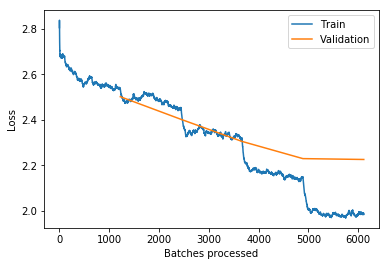

In [59]:
lmlearn.recorder.plot_losses()

All that work was done to get the best language model I could get which seems to have
accuracy of about 51%

Now on to training the classifier

In [63]:
f1 = FBeta(beta=1, average = 'binary')
def train_triage_classifier(encoder_name, datac = data_clas, datal = data_lm, 
                            mets = [accuracy,f1], num_cycles = 1, lr = 1e-2, drop_mult = 0.5):
    model = text_classifier_learner(datac, metrics = mets, arch = AWD_LSTM, drop_mult=drop_mult)
    model.load_encoder(model_path + '/' + encoder_name)
    model.fit_one_cycle(num_cycles, lr, moms=(0.8,0.7))
    model.freeze_to(-2)
    model.fit_one_cycle(num_cycles, slice(lr/(2.6**4),lr), moms=(0.8,0.7))
    model.freeze_to(-3)
    model.fit_one_cycle(num_cycles, slice((lr/2)/(2.6**4),(lr/2)), moms=(0.8,0.7))
    model.unfreeze()
    model.fit_one_cycle(num_cycles*5, slice((lr/100)/(2.6**4),(lr/100)), moms=(0.8,0.7))
    model.recorder.plot_losses()
    return model

#### first pass at training classifier (I am using the small dataset here)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.258108,0.271953,0.901150,0.947678,04:05


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.271711,0.270886,0.901053,0.947640,05:07


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.255870,0.268282,0.900955,0.947602,08:41


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.260550,0.267756,0.902320,0.948228,10:41
1,0.263945,0.267451,0.902613,0.948391,11:01
2,0.245782,0.267676,0.901735,0.947982,10:53
3,0.271788,0.268039,0.900663,0.947281,11:01
4,0.261068,0.268137,0.901930,0.948000,11:02


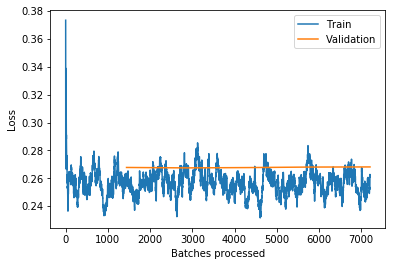

In [65]:
sent_learn = train_triage_classifier('edsent_subjcombo_enc', num_cycles = 1, lr = 1e-3)

In [66]:
preds, targets = sent_learn.get_preds(DatasetType.Valid) 
predictions = np.argmax(preds, axis = 1) 

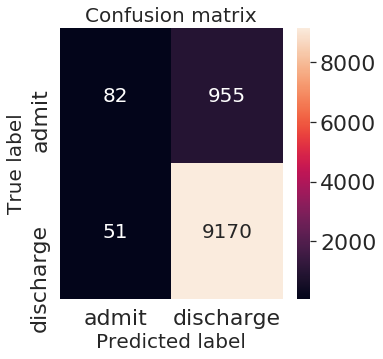

In [67]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

LABELS = data_clas.classes

confusion_matrix = metrics.confusion_matrix(targets, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [69]:
sent_learn.save(model_path + '/edtriage_combo_bin')

In [ ]:
data_clas = (TextList.from_df(data, cols='combo',vocab=data_lm.vocab)
                   .split_by_rand_pct(0.1)
                   .label_from_df(cols = 'outcome')
                   .databunch())